# Import required packages

Import Numpy

In [ ]:
import numpy as np

Import Pandas

In [ ]:
import pandas as pd

Import Pyplot from Matplotlib

In [ ]:
import matplotlib.pyplot as plt

Import Scikit Learn Modules

In [ ]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

Import Seaborn

In [ ]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import Pickle

In [ ]:
import pickle

Import Tensorflow

In [ ]:
import tensorflow as tf

Import keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


# Dataset ETL

Loading of Rankings Dataset

In [ ]:
rankings_path = "/content/fifa_ranking.csv"
matches_path = "/content/results.csv"

In [ ]:
#read ranking file
rankings_df = pd.read_csv(rankings_path)

Load Matches Dataset

In [ ]:
#read match results file
matches_df = pd.read_csv(matches_path)

# Data Preprocessing

Preprocessing of Rankings dataset

In [ ]:
#select required columns
rankings_df = rankings_df.loc[:,['rank', 'country_full', 'cur_year_avg_weighted', 'rank_date', 'two_year_ago_weighted', 'three_year_ago_weighted', 'confederation']]
#aggregate points
rankings_df['weighted_points'] =  rankings_df['cur_year_avg_weighted'] + rankings_df['two_year_ago_weighted'] + rankings_df['three_year_ago_weighted']
#convert date string to date object
rankings_df['rank_date'] = pd.to_datetime(rankings_df['rank_date'])
#extract year from date
rankings_df['rank_year'] = pd.DatetimeIndex(rankings_df['rank_date']).year
#extract useful columns
rankings_df = rankings_df.loc[:, ['rank', 'country_full', 'weighted_points', 'rank_year']]
#aggregate rank and points
rankings_df = rankings_df.groupby(['country_full', 'rank_year']).mean().reset_index()

Display rows of Rankings dataset

In [ ]:
rankings_df

,country_full,rank_year,rank,weighted_points
0,Afghanistan,2003,199.000000,0.000000
1,Afghanistan,2004,197.500000,0.000000
2,Afghanistan,2005,198.833333,0.000000
3,Afghanistan,2006,181.454545,0.000000
4,Afghanistan,2007,186.250000,0.000000
...,...,...,...,...
5250,Zimbabwe,2014,99.750000,252.050000
5251,Zimbabwe,2015,114.250000,198.882500
5252,Zimbabwe,2016,115.583333,248.017500
5253,Zimbabwe,2017,105.833333,234.076667


Preprocessing of Match Results dataset

In [ ]:
#convert date string to date object
matches_df['date'] = pd.to_datetime(matches_df['date'])
#extract year from date
matches_df['match_year'] = pd.DatetimeIndex(matches_df['date']).year
matches_df = matches_df.loc[:, ['match_year', 'home_team', 'away_team', 'home_score', 'away_score', 'neutral', 'tournament']]

Display rows of Match Results dataset

In [ ]:
matches_df

,match_year,home_team,away_team,home_score,away_score,neutral,tournament
0,1872,Scotland,England,0,0,False,Friendly
1,1873,England,Scotland,4,2,False,Friendly
2,1874,Scotland,England,2,1,False,Friendly
3,1875,England,Scotland,2,2,False,Friendly
4,1876,Scotland,England,3,0,False,Friendly
...,...,...,...,...,...,...,...
41581,2020,Barbados,Canada,1,4,True,Friendly
41582,2020,Kosovo,Sweden,0,1,True,Friendly
41583,2020,Canada,Iceland,0,1,True,Friendly
41584,2020,El Salvador,Iceland,0,1,True,Friendly


Join the two datasets

In [ ]:
merged_df = matches_df.merge(rankings_df, how='left', left_on=['match_year', 'home_team'], right_on=['rank_year', 'country_full'])
merged_df = merged_df.merge(rankings_df, how='left', left_on=['match_year', 'away_team'], right_on=['rank_year', 'country_full'], suffixes=('_home', '_away'))
merged_df = merged_df.dropna()
merged_df.reset_index(inplace=True)

Display rows of merged datasets

In [ ]:
merged_df

,index,match_year,home_team,away_team,home_score,away_score,neutral,tournament,country_full_home,rank_year_home,rank_home,weighted_points_home,country_full_away,rank_year_away,rank_away,weighted_points_away
0,17374,1993,Ghana,Mali,1,1,True,Friendly,Ghana,1993.0,41.600000,0.000000,Mali,1993.0,72.400000,0.000000
1,17375,1993,Gabon,Burkina Faso,1,1,False,Friendly,Gabon,1993.0,57.000000,0.000000,Burkina Faso,1993.0,121.000000,0.000000
2,17376,1993,Kuwait,Lebanon,2,0,False,Friendly,Kuwait,1993.0,62.200000,0.000000,Lebanon,1993.0,109.400000,0.000000
3,17377,1993,Burkina Faso,Mali,1,0,True,Friendly,Burkina Faso,1993.0,121.000000,0.000000,Mali,1993.0,72.400000,0.000000
4,17378,1993,Gabon,Ghana,2,3,False,Friendly,Gabon,1993.0,57.000000,0.000000,Ghana,1993.0,41.600000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18414,40415,2018,Iraq,Palestine,1,0,True,Friendly,Iraq,2018.0,86.333333,340.760000,Palestine,2018.0,83.166667,351.638333
18415,40416,2018,United Arab Emirates,Kuwait,0,2,False,Friendly,United Arab Emirates,2018.0,79.000000,304.606667,Kuwait,2018.0,169.333333,107.161667
18416,40418,2018,Australia,Oman,5,0,True,Friendly,Australia,2018.0,37.500000,544.818333,Oman,2018.0,93.833333,305.090000
18417,40419,2018,Yemen,Syria,0,1,True,Friendly,Yemen,2018.0,133.166667,147.311667,Syria,2018.0,75.000000,314.398333


# Data Model Planning

Generate required features in merged dataset

In [ ]:
merged_df['rank_difference'] = merged_df['rank_home'] - merged_df['rank_away']
merged_df['average_rank'] = (merged_df['rank_home'] + merged_df['rank_away'])/2
merged_df['point_difference'] = merged_df['weighted_points_home'] - merged_df['weighted_points_away']
merged_df['score_difference'] = merged_df['home_score'] - merged_df['away_score']
merged_df['is_won'] = 'tie'
merged_df.loc[merged_df['score_difference'] > 0, 'is_won'] = 'yes'#merged_df['score_difference'] > 0 # take draw as lost
merged_df.loc[merged_df['score_difference'] < 0, 'is_won'] = 'no'
merged_df.loc[merged_df['score_difference'] == 0, 'is_won'] = 'tie'
merged_df['is_stake'] = merged_df['tournament'] != 'Friendly'

Encode tournament feature

In [ ]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(merged_df['tournament'])
merged_df['tournament']=label_encoder.transform(merged_df['tournament'])

Encode is won

In [ ]:
label_encoder_won = preprocessing.LabelEncoder()
label_encoder_won.fit(merged_df['is_won'])
merged_df['is_won']=label_encoder_won.transform(merged_df['is_won'])

Encode home team

In [ ]:
label_encoder_home = preprocessing.LabelEncoder()
label_encoder_home.fit(merged_df['home_team'])
merged_df['home_team']=label_encoder_home.transform(merged_df['home_team'])

Encode away team

In [ ]:
label_encoder_away = preprocessing.LabelEncoder()
label_encoder_away.fit(merged_df['away_team'])
merged_df['away_team']=label_encoder_away.transform(merged_df['away_team'])

# Feature Selection - Dimensionality Reduction

Select Required Features

In [ ]:
X_df = merged_df.loc[:,['home_team', 'away_team', 'rank_difference', 'point_difference', 'average_rank', 'tournament', 'is_stake', 'neutral']]
y_df = merged_df['is_won']

Outlier Detection

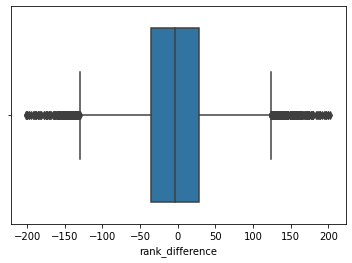

In [ ]:
sns.boxplot(x=X_df['rank_difference'])

In [ ]:
median = X_df['rank_difference'].median()
std = X_df['rank_difference'].std()
outliers = (X_df['rank_difference'] - median).abs() > std
X_df.loc[outliers, 'rank_difference'] = median

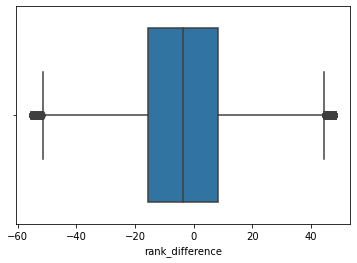

In [ ]:
sns.boxplot(x=X_df['rank_difference'])

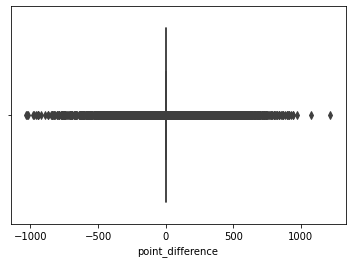

In [ ]:
sns.boxplot(x=X_df['point_difference'])

In [ ]:
median = X_df['point_difference'].median()
std = X_df['point_difference'].std()
outliers = (X_df['point_difference'] - median).abs() > std
X_df.loc[outliers, 'point_difference'] = median

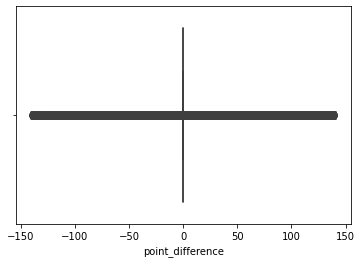

In [ ]:
sns.boxplot(x=X_df['point_difference'])

Generate Heat Map of features

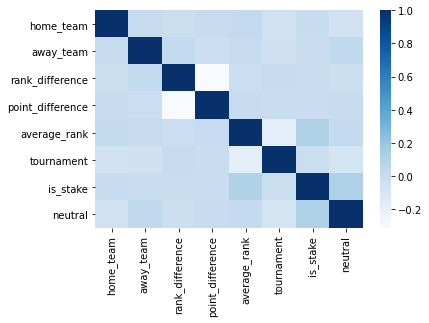

In [ ]:
sns.heatmap(X_df.corr(), cmap="Blues")

Split dataset for training and testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

# Data Model Building

Logistic Regression Classifier Model

Create model (Design)

In [ ]:
logistic_regression = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
logistic_regression_model = Pipeline([('polynomial_features', features),('logistic_regression', logistic_regression)])

Train the model

In [ ]:
logistic_regression_model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('polynomial_features',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('logistic_regression',
                 LogisticRegression(C=1e-05, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

Test the model

In [ ]:
logistic_regression_model.score(X_test, y_test)

0.5162866449511401

Save the model for further use

In [ ]:
pickle.dump(logistic_regression_model, open("logistic_regression_model", 'wb'))

Naive Bayes Model

Create model

In [ ]:
naive_bayes_model = GaussianNB()

Train the model

In [ ]:
naive_bayes_model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Test the model

In [ ]:
y_pred = naive_bayes_model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5200868621064061


Save the model for further use

In [ ]:
pickle.dump(naive_bayes_model, open("naive_bayes_model", 'wb'))

KNN Model

Create model

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=3)

Train the model

In [ ]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Test the model

In [ ]:
y_pred = knn_model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.46226927252985883


Save the model for further use

In [ ]:
pickle.dump(knn_model, open("knn_model", 'wb'))

SVM model

Create model

In [ ]:
svm_model = svm.SVC(kernel='poly', probability=True)

Train the model

In [ ]:
svm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Test the model

In [ ]:
y_pred = svm_model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5190010857763301


Save the model

In [ ]:
pickle.dump(svm_model, open("svm_model", 'wb'))

Neural Network Model

Encode is won to one hot

In [ ]:
y_train_nn = np.expand_dims(y_train, axis=1)

In [ ]:
one_hot_encoder = preprocessing.OneHotEncoder()
one_hot_encoder.fit_transform(y_train_nn)
y_train_nn = one_hot_encoder.transform(y_train_nn).toarray()

Define model

In [ ]:
nn_model = Sequential()
nn_model.add(Dense(32, input_shape=(X_train.shape[-1],), activation='sigmoid'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(3, activation='relu'))

Compile Model

In [ ]:
nn_model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])

Train model

In [ ]:
nn_model.fit(X_train, y_train_nn, epochs=20)

Epoch 1/20
14735/14735 [==============================] - 0s 30us/step - loss: 1.0896 - accuracy: 0.4746
Epoch 2/20
14735/14735 [==============================] - 0s 26us/step - loss: 1.0233 - accuracy: 0.4916
Epoch 3/20
14735/14735 [==============================] - 0s 26us/step - loss: 1.0147 - accuracy: 0.4976
Epoch 4/20
14735/14735 [==============================] - 0s 26us/step - loss: 1.0115 - accuracy: 0.5000
Epoch 5/20
14735/14735 [==============================] - 0s 26us/step - loss: 1.0075 - accuracy: 0.5042
Epoch 6/20
14735/14735 [==============================] - 0s 27us/step - loss: 1.0052 - accuracy: 0.5030
Epoch 7/20
14735/14735 [==============================] - 0s 26us/step - loss: 1.0034 - accuracy: 0.5069
Epoch 8/20
14735/14735 [==============================] - 0s 26us/step - loss: 1.0021 - accuracy: 0.5061
Epoch 9/20
14735/14735 [==============================] - 0s 27us/step - loss: 1.0011 - accuracy: 0.5078
Epoch 10/20
14735/14735 [==============================

Save neural network model

In [ ]:
nn_model.save_weights("nn_model.h5")

# Prediction / Results

Results of logistic regression model

Load model

In [ ]:
loaded_model = pickle.load(open("logistic_regression_model", 'rb'))

Predict Accuracy

In [ ]:
logistic_regression_model.score(X_test, y_test)

0.5162866449511401

Results of naive bayes model

Load model

In [ ]:
loaded_model = pickle.load(open("naive_bayes_model", 'rb'))

Predict Accuracy

In [ ]:
y_pred = naive_bayes_model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5200868621064061


Results of knn model

Load model

In [ ]:
loaded_model = pickle.load(open("knn_model", 'rb'))

Predict Accuracy

In [ ]:
y_pred = knn_model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.46226927252985883


Results of svm model

Load model

In [ ]:
loaded_model = pickle.load(open("svm_model", 'rb'))

Predict Accuracy

In [ ]:
y_pred = svm_model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5190010857763301


Results of neural network model

Load model

In [ ]:
nn_model.load_weights('nn_model.h5')

Predict Accuracy

In [ ]:
predictions = model.predict_classes(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, predictions))

Accuracy: 0.5138436482084691


Function to get prediction

In [ ]:
def predict_match(home_team, away_team, home_rank, away_rank, home_points, away_points, tournament, is_stake, neutral):
    rank_difference = home_rank - away_rank
    point_difference = home_points - away_points
    average_rank = (home_rank + away_rank) / 2
    data = {'home_team':label_encoder_home.transform([home_team]), 'away_team':label_encoder_away.transform([away_team]), 'rank_difference':rank_difference, 'point_difference':point_difference, 'average_rank':average_rank, 'tournament':label_encoder.transform([tournament]), 'is_stake':is_stake, 'neutral':neutral}
    data_frame = pd.DataFrame(data, columns=['home_team', 'away_team', 'rank_difference', 'point_difference', 'average_rank', 'tournament', 'is_stake', 'neutral'])
    if(naive_bayes_model.predict(data_frame)[0] == 1):
        print(home_team + " will win")
    elif(naive_bayes_model.predict(data_frame)[0] == 2):
        print(away_team + " will win")
    else:
        print("Match will end in a tie")

Call function to predict between Germany and Switzerland

In [ ]:
predict_match('Germany', 'Switzerland', 1, 10, 900, 700, 'UEFA Euro', True, False)

Switzerland will win


# Visualization

Confusion Matrix for logistic regression model

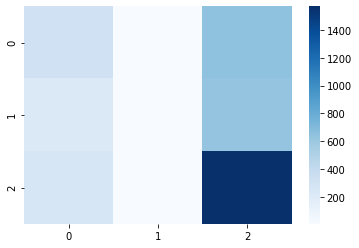

In [ ]:
cm = confusion_matrix(y_test, logistic_regression_model.predict(X_test))
sns.heatmap(cm, cmap="Blues")

Confusion Matrix for naive bayes model

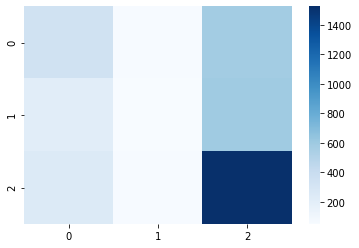

In [ ]:
cm = confusion_matrix(y_test, naive_bayes_model.predict(X_test))
sns.heatmap(cm, cmap="Blues")

Confusion Matrix for knn model

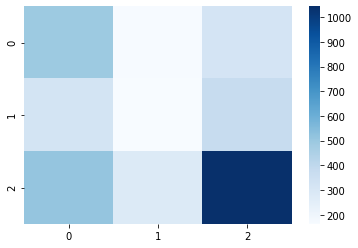

In [ ]:
cm = confusion_matrix(y_test, knn_model.predict(X_test))
sns.heatmap(cm, cmap="Blues")

Confusion Matrix for svm model

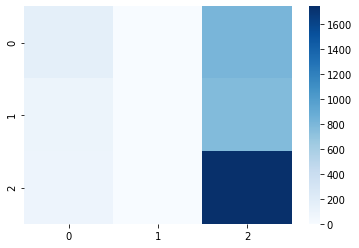

In [ ]:
cm = confusion_matrix(y_test, svm_model.predict(X_test))
sns.heatmap(cm, cmap="Blues")

Confusion matrix for neural network model

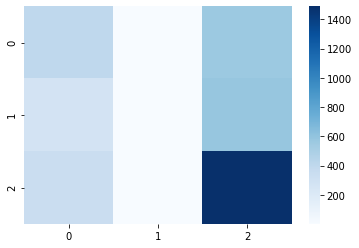

In [ ]:
predictions = nn_model.predict_classes(X_test)
cm = confusion_matrix(y_test.to_numpy(), predictions)
sns.heatmap(cm, cmap="Blues")

Frequency of predicted values

In [ ]:
unique_elements, counts_elements = np.unique(predictions, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1    2]
 [1031   10 2643]]


Pie Chart representing wins, losses, ties

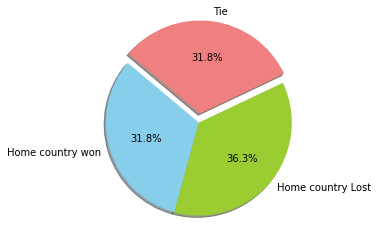

In [ ]:
labels = 'Home country won', 'Home country Lost', 'Tie'
sizes = [len(merged_df.loc[merged_df['is_won']==True]), len(merged_df.loc[merged_df['is_won']==False]),len(merged_df.loc[merged_df['away_score']==merged_df['home_score']])]
colors = ['skyblue', 'yellowgreen', 'lightcoral']
explode = (0, 0, 0.1)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

Function to show change in ranks and poinsts over time

In [ ]:
rankings_df.dtypes

country_full        object
rank_year            int64
rank               float64
weighted_points    float64
dtype: object

In [ ]:
def plot_graph(a,b): 
  # x axis values 
  x =  rankings_df['rank_year'].loc[rankings_df['country_full']==a]
  # corresponding y axis values 
  y =  rankings_df[b].loc[rankings_df['country_full']==a]
    
  # plotting the points  
  plt.plot(x, y)  
  
  
  # naming the x axis 
  plt.xlabel('Year') 
  # naming the y axis 
  plt.ylabel(b) 
    
  # giving a title to my graph 
  plt.title('Change in ' + b + ' of ' + a) 
    
  # function to show the plot 
  plt.show()

Plot rank of Germany

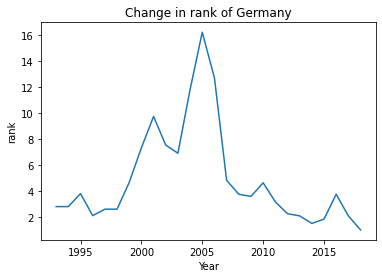

In [ ]:
plot_graph('Germany','rank')

Plot rank of Switzerland

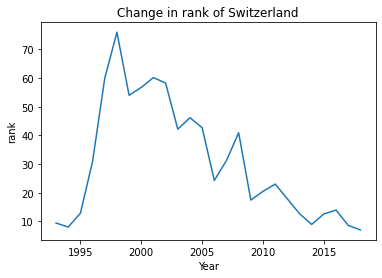

In [ ]:
plot_graph('Switzerland','rank')

Generate data for confederations

In [ ]:
rankings_df = pd.read_csv("/home/anish/Engineering/TE/Sem2/SL6/Mini Project/fifa_ranking.csv")
rankings_df = rankings_df.loc[:,['rank', 'country_full', 'cur_year_avg_weighted', 'rank_date', 'two_year_ago_weighted', 'three_year_ago_weighted', 'confederation']]
group1=rankings_df['confederation'].unique()
group1
mean_rank=[]
mean_points=[]
for a in group1:
  c=rankings_df['rank'].loc[rankings_df['confederation']==a].mean()
  d=rankings_df['rank'].loc[rankings_df['confederation']==a].mean()
  mean_rank.append(c)
  mean_points.append(d)

Ranks by confederation

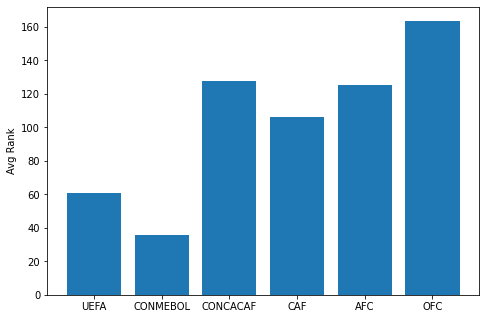

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(group1,mean_rank)
ax.set_ylabel('Avg Rank')
plt.show()

Points by confederation

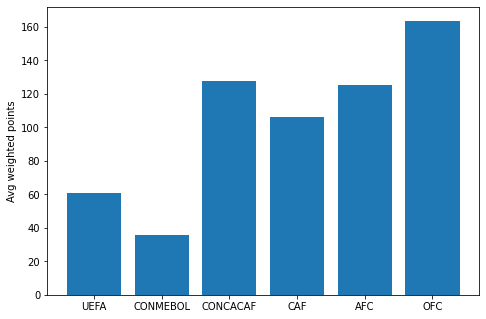

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(group1,mean_points)
ax.set_ylabel('Avg weighted points')
plt.show()